In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate

In [14]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
dimension = 2**9
print(dimension)
rho0 = 0.1
# dx = 0.25
dx = 1/dimension

obs_size = int(dimension/2)
H = assimilate.random_H(dimension, obs_size)

# H = np.eye(dimension)[::2]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [6]:
eig_val, eig_vec, P, sort_ind = covariance.generate_circulant(
    dimension, dx, rho0, covariance.fft_sqd_exp_1d,
    return_Corr=True,
    return_sort_ind=True)
eig_val = eig_val * (eig_val.size/eig_val.sum())
eig_vec = eig_vec.real + eig_vec.imag
# sort_ind = np.argsort(sort_ind)
# eig_val = eig_val[sort_ind]
# eig_vec = eig_vec[:, sort_ind]
# eig_val = np.fft.fftshift(eig_val)
# eig_vec = np.fft.fftshift(eig_vec, axes=1)

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

R = np.eye(obs_size)

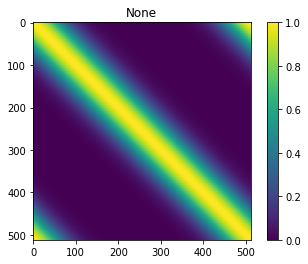

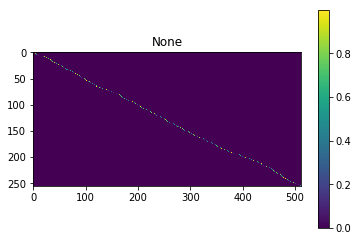

In [7]:
imshow(P, vmin=0)
imshow(H)

In [8]:
trans_mats = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    exec(key + '=val')

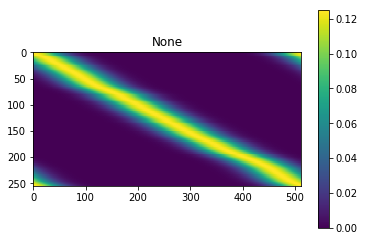

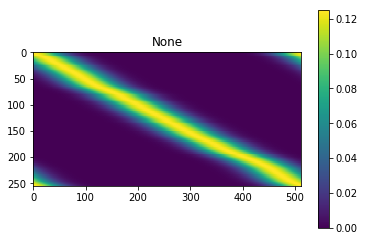

In [15]:
imshow(U @ S @ VT)
imshow(H @ P_sqrt)

/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


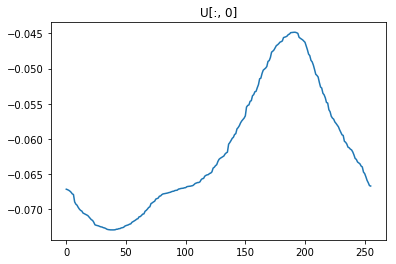

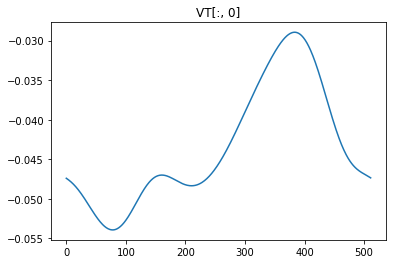

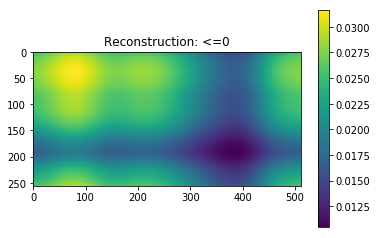

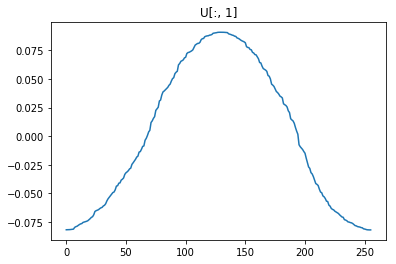

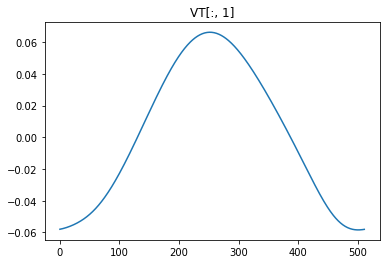

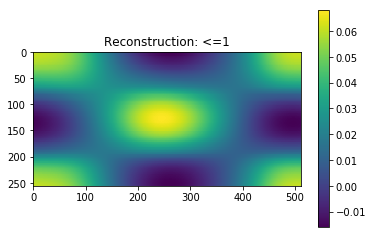

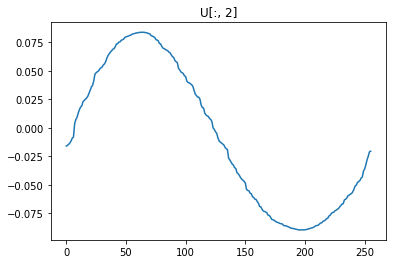

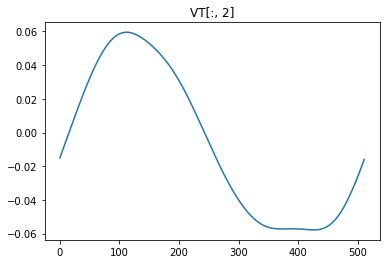

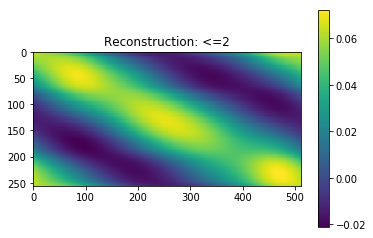

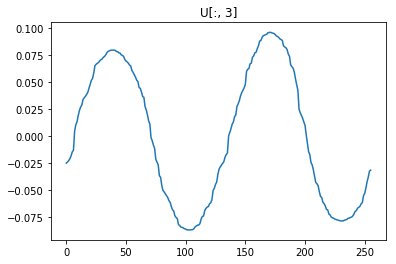

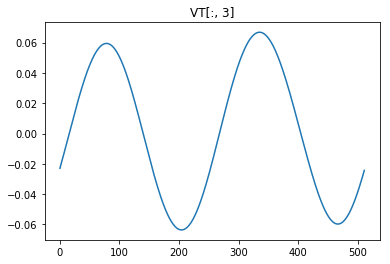

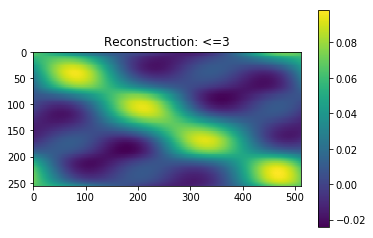

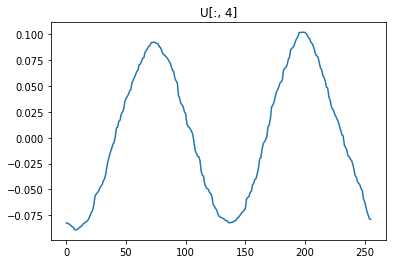

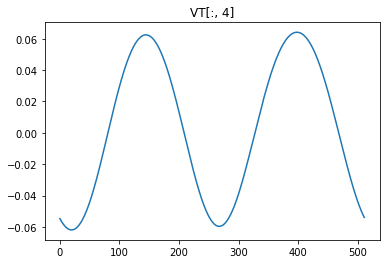

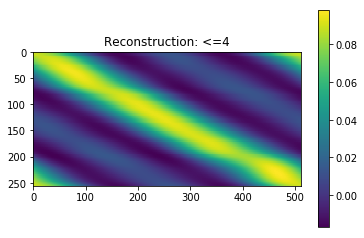

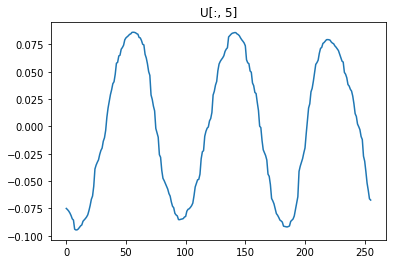

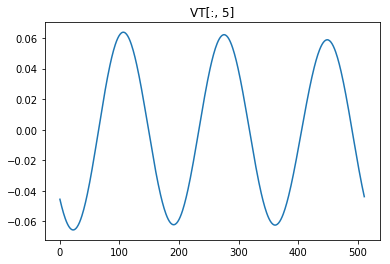

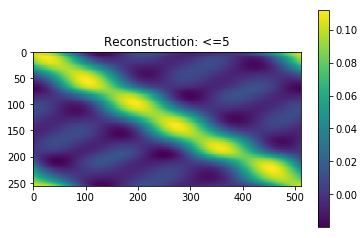

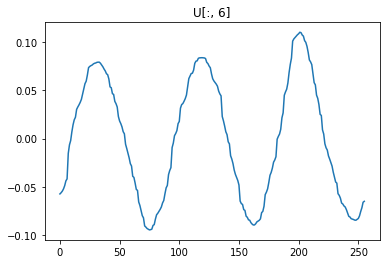

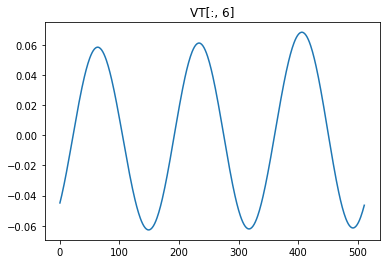

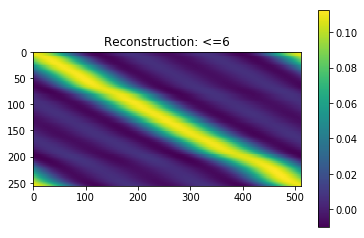

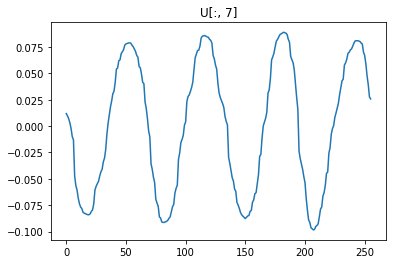

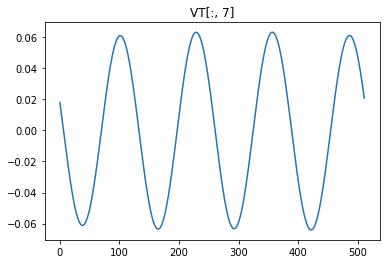

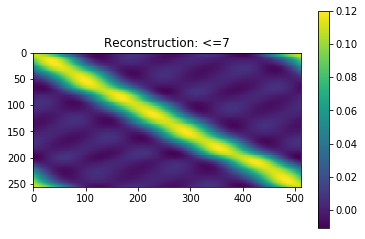

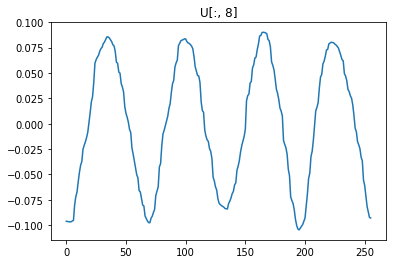

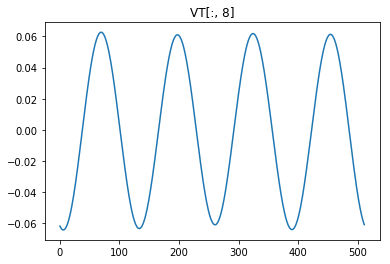

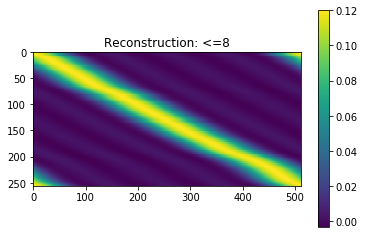

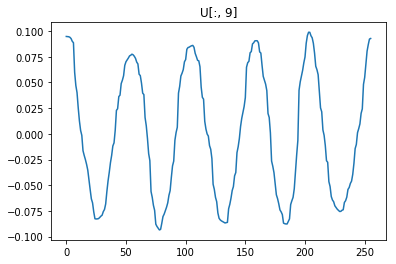

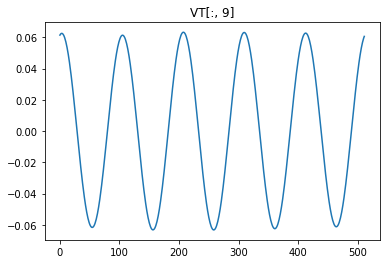

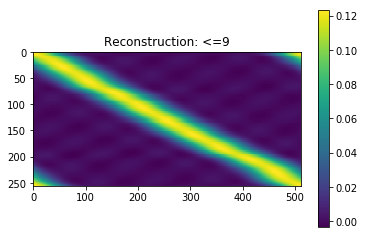

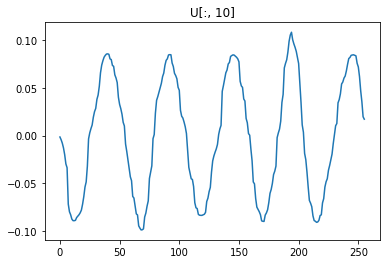

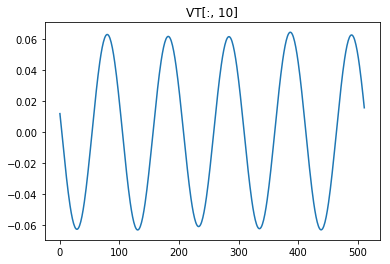

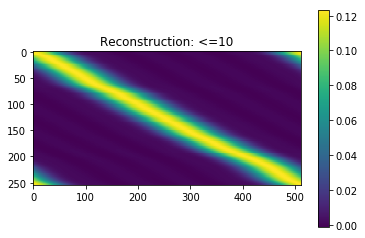

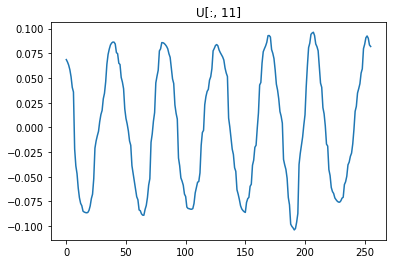

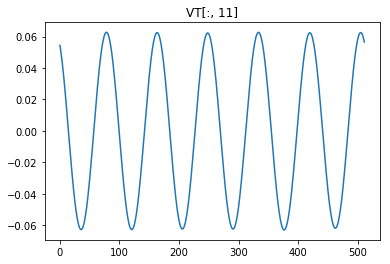

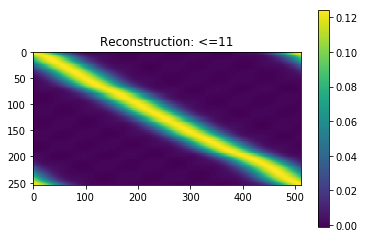

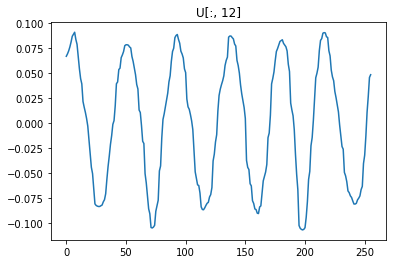

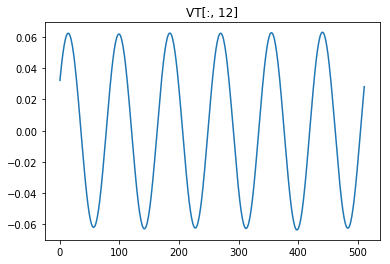

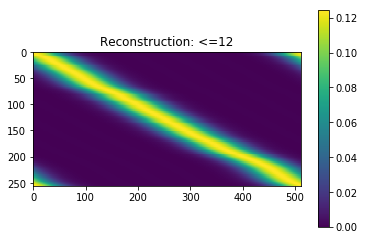

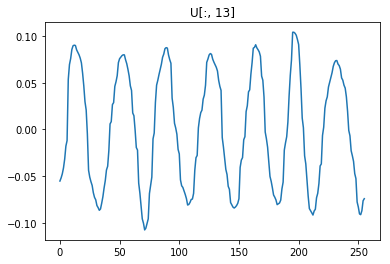

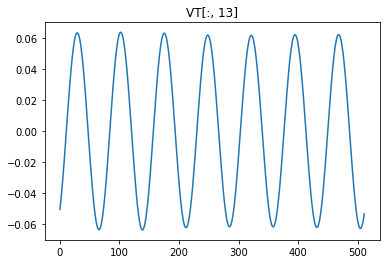

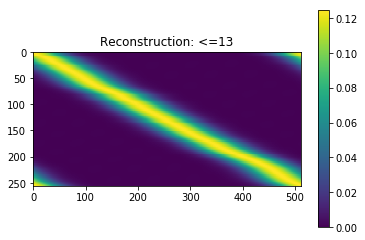

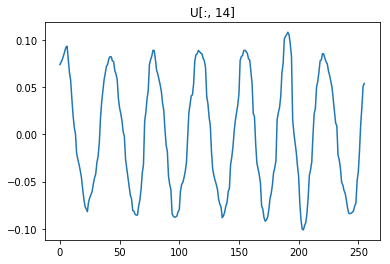

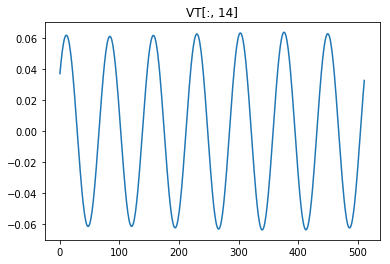

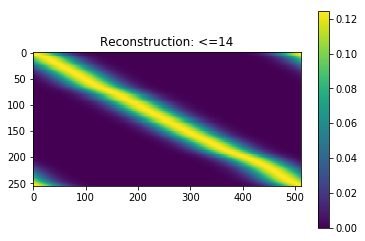

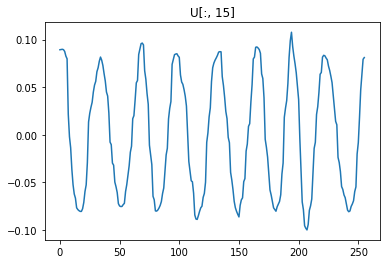

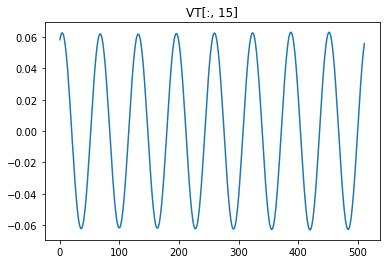

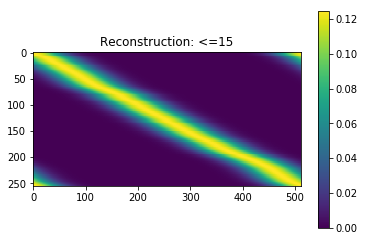

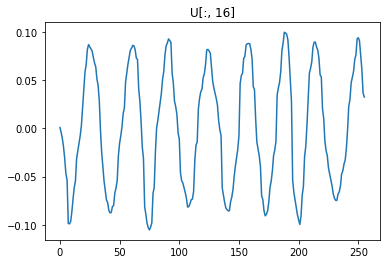

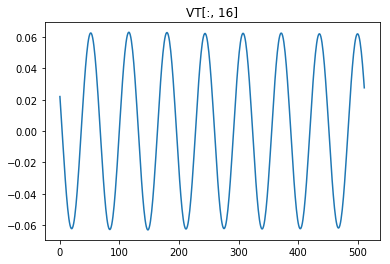

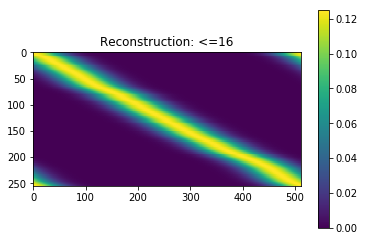

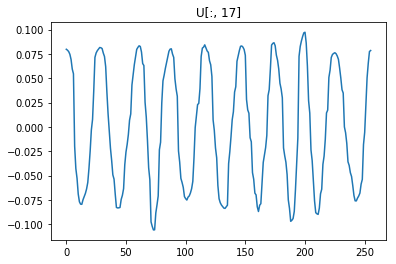

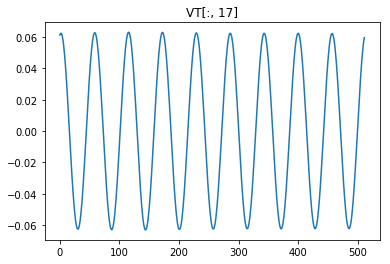

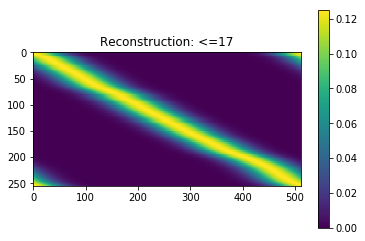

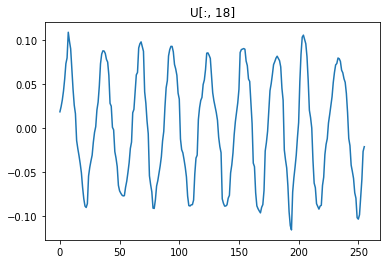

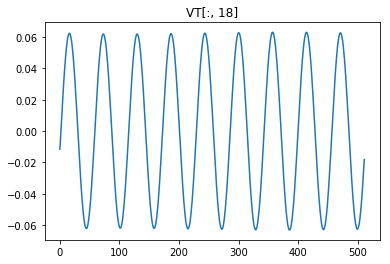

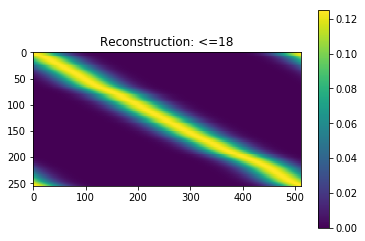

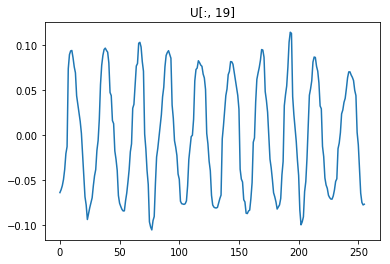

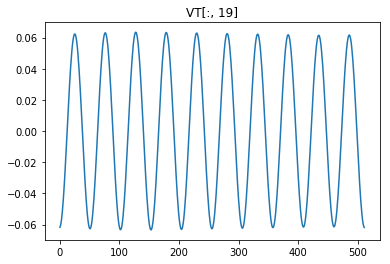

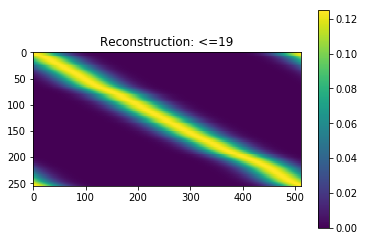

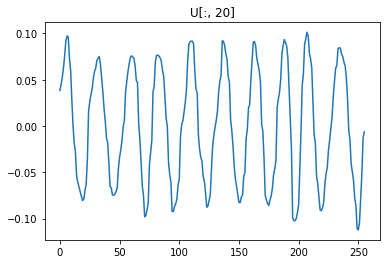

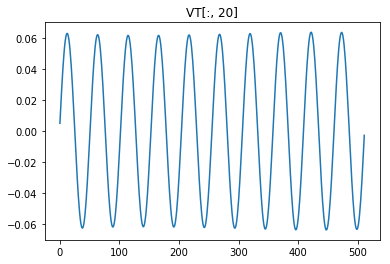

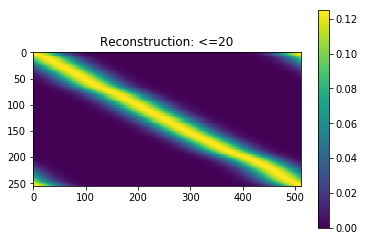

In [16]:
prev = np.zeros_like(S)
for ii in range(21):
    plt.figure()
    plt.plot(U[:, ii])
    plt.title(f'U[:, {ii}]')
    
    plt.figure()
    plt.plot(VT[ii])
    plt.title(f'VT[:, {ii}]')
    
    prev += (S.diagonal()[ii]
             * U[:, ii:ii+1]
             @ VT[ii:ii + 1])
    
    imshow(prev, f'Reconstruction: <={ii}')

In [73]:
ens_size = 30
mu = np.zeros(dimension)

In [74]:
ensemble = assimilate.generate_ensemble(
    ens_size, mu, trans_mats['P_sqrt'])

In [75]:
rho0

0.1

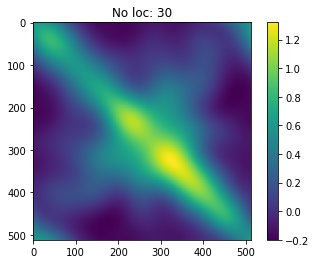

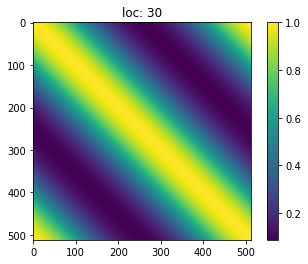

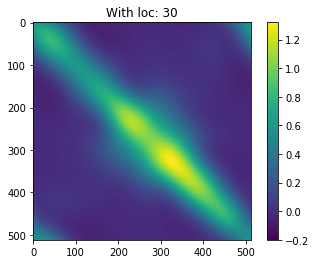

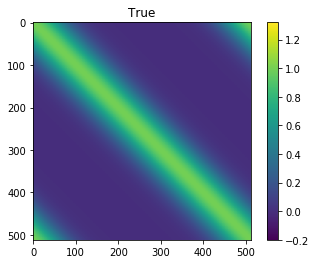

In [76]:
rho_loc = 0.2
[loc] = covariance.generate_circulant(
    dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_eig=False)
loc /= loc.max()
P_sample = np.cov(ensemble)
vmin = P_sample.min()
vmax = np.max([P_sample.max(), 1])
imshow(P_sample,
       vmin=vmin, vmax=vmax,
       title=f'No loc: {ens_size}')

imshow(loc,
       title=f'loc: {ens_size}')
imshow(P_sample * loc,
       vmin=vmin, vmax=vmax,
       title=f'With loc: {ens_size}')
imshow(P,
       vmin=vmin, vmax=vmax,
       title=f'True')

In [77]:
trans_mats_sample = assimilate.transformation_matrices(
        H, P=P_sample,
        R=R, return_Ts=True)
U_sample = trans_mats_sample['U']
S_sample = trans_mats_sample['S']
VT_sample = trans_mats_sample['VT']

Text(0.5,0,'localization radius')

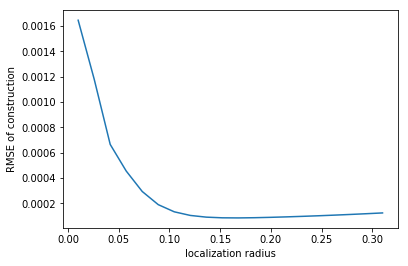

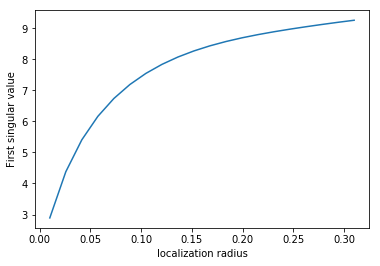

In [78]:
sig_num = 5
reduced_true = U[:, :sig_num] @ S[:sig_num, :sig_num] @ VT[:sig_num]
# imshow(reduced_true, f'Reduced true; sig_num: {sig_num}')
rho_array = np.linspace(.31, 0.01, 20)
rmse = np.ones_like(rho_array) * np.nan
first_singular = rmse.copy()
for count, rho_loc in enumerate(rho_array):
    [loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max() 
    P_loc = P_sample * loc
#     imshow(P_loc, f'P_loc: {rho_loc:0.3}')
    this_trans_mats = assimilate.transformation_matrices(
        H, P=P_loc,
        R=R, return_Ts=True)
    aU = this_trans_mats['U']
    aS = this_trans_mats['S']
    aVT = this_trans_mats['VT']
    first_singular[count] = aS[0,0]
    this_reduced = (aU[:, :sig_num]
                    @ aS[:sig_num, :sig_num]
                    @ aVT[:sig_num])
#     imshow(this_reduced, f'Reduced sample; rho: {rho_loc:0.3}')
    error = this_reduced - reduced_true
    rmse[count] = (error ** 2).mean()
#     imshow(error, f'Error; rmse: {rmse[count]:0.4}')
    
plt.figure()
plt.plot(rho_array, rmse)
plt.ylabel('RMSE of construction')
plt.xlabel('localization radius')


plt.figure()
plt.plot(rho_array, first_singular)
plt.ylabel('First singular value')
plt.xlabel('localization radius')

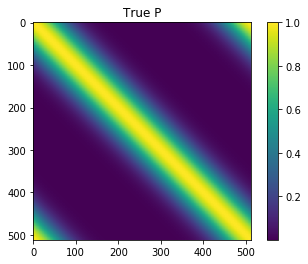

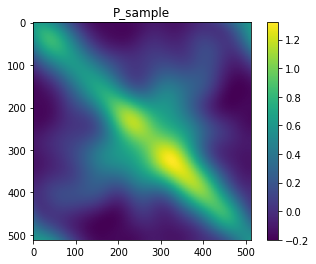

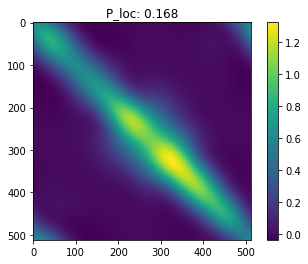

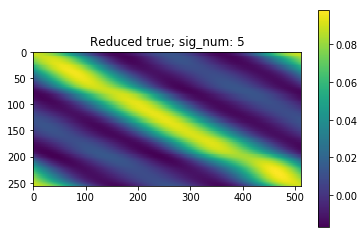

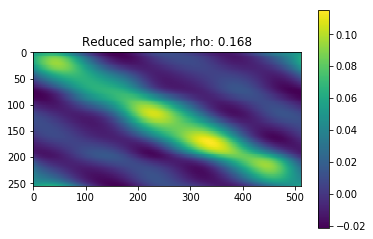

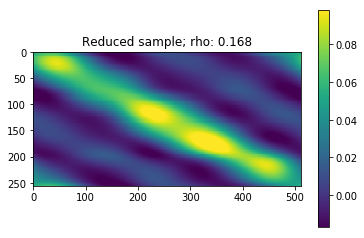

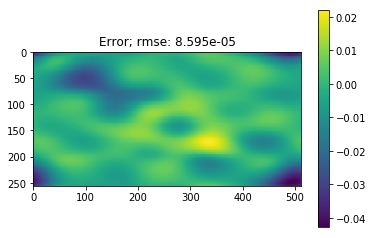

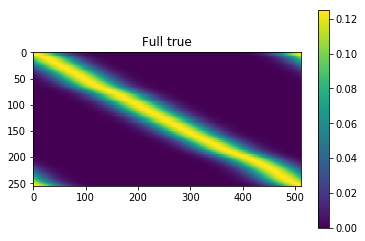

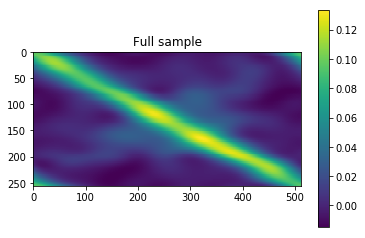

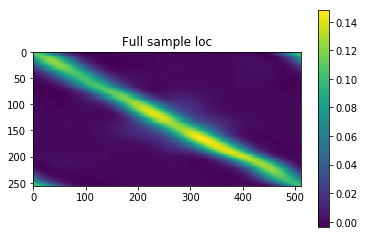

In [79]:
min_index = rmse.argmin()
rho_min = rho_array[min_index]

rho_loc = rho_min
[loc] = covariance.generate_circulant(
    dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_eig=False)
loc /= loc.max() 
P_loc = P_sample * loc
imshow(P, f'True P')
imshow(P_sample, 'P_sample')
imshow(P_loc, f'P_loc: {rho_loc:0.3}')

this_trans_mats = assimilate.transformation_matrices(
    H, P=P_loc,
    R=R, return_Ts=True)
aU = this_trans_mats['U']
aS = this_trans_mats['S']
aVT = this_trans_mats['VT']
this_reduced = (aU[:, :sig_num]
                @ aS[:sig_num, :sig_num]
                @ aVT[:sig_num])
imshow(reduced_true, f'Reduced true; sig_num: {sig_num}')
imshow(this_reduced, f'Reduced sample; rho: {rho_loc:0.3}')
imshow(this_reduced, f'Reduced sample; rho: {rho_loc:0.3}',
       vmin=reduced_true.min(), vmax=reduced_true.max())
error = this_reduced - reduced_true
rmse[count] = (error ** 2).mean()
imshow(error, f'Error; rmse: {rmse[count]:0.4}')

full = (aU @ aS @ aVT)
full_sample = (U_sample @ S_sample @ VT_sample)
imshow(H @ P_sqrt, f'Full true')
imshow(full_sample, f'Full sample')
imshow(full, f'Full sample loc')

In [112]:
dimension = 2**9
print(dimension)
rho0 = 0.1
# dx = 0.25
dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

# H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [113]:
eig_val, eig_vec, P, sort_ind = covariance.generate_circulant(
    dimension, dx, rho0, covariance.fft_sqd_exp_1d,
    return_Corr=True,
    return_sort_ind=True)
eig_val = eig_val * (eig_val.size/eig_val.sum())
eig_vec = eig_vec.real + eig_vec.imag
# sort_ind = np.argsort(sort_ind)
# eig_val = eig_val[sort_ind]
# eig_vec = eig_vec[:, sort_ind]
# eig_val = np.fft.fftshift(eig_val)
# eig_vec = np.fft.fftshift(eig_vec, axes=1)

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

R = np.eye(obs_size)

In [114]:
trans_mats = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    exec(key + '=val')

In [228]:
ens_ens_size = 10
ens_size = 50
mu = np.zeros(dimension)
ensemble_array = np.ones(
    [dimension, ens_size, ens_ens_size,
    ]) * np.nan
for t_num in range(ens_ens_size):
    ensemble_array[:, :, t_num] = (
        assimilate.generate_ensemble(
            ens_size, mu, trans_mats['P_sqrt']))

In [229]:
P_sample_array = np.zeros([dimension, dimension, ens_ens_size])
for i in range(ens_ens_size):
    P_sample_array[:, :, i] = np.cov(ensemble_array[:, :, i])

In [231]:
sig_num = 5
reduced_true = U[:, :sig_num] @ S[:sig_num, :sig_num] @ VT[:sig_num]
# imshow(reduced_true, f'Reduced true; sig_num: {sig_num}')

rho_array = np.linspace(.31, 0.005, 40)
# rho_array = np.linspace(.31, 0.005, 2)

error_n2 = np.ones([rho_array.size, ens_ens_size]) * np.nan
reduced_mean = np.ones([obs_size, dimension, rho_array.size])
reduced_var = np.ones([obs_size, dimension, rho_array.size])
s_array = np.ones([sig_num, rho_array.size, ens_ens_size])
U_array = np.ones([obs_size, sig_num, rho_array.size, ens_ens_size])
V_array = np.ones([dimension, sig_num, rho_array.size, ens_ens_size])

# ##
# P_var = np.ones([dimension, dimension, rho_array.size])
# P_sqrt_var = np.ones([dimension, dimension, rho_array.size])
# ##
for rho_count, rho_loc in enumerate(rho_array):
    [loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max()
    reduced_array = np.ones([obs_size,
                             dimension,
                             ens_ens_size]) * np.nan
#     ##
#     P_array = np.ones([dimension,
#                        dimension,
#                        ens_ens_size]) * np.nan
#     P_sqrt_array = P_array.copy()
#     ##
    for ens_count in range(ens_ens_size):
        P_loc = P_sample_array[:, :, ens_count] * loc
    #     imshow(P_loc, f'P_loc: {rho_loc:0.3}')
        
        this_trans_mats = assimilate.transformation_matrices(
            H, P=P_loc,
            R=R, return_Ts=True)
        aU = this_trans_mats['U']
        aS = this_trans_mats['S']
        aVT = this_trans_mats['VT']
        s_array[:sig_num, rho_count, ens_count] = aS.diagonal()[:sig_num]
        U_array[:, :sig_num, rho_count, ens_count] = aU[:, :sig_num]
        V_array[:, :sig_num, rho_count, ens_count] = aVT[:sig_num, :].T
        
        reduced_array[:, :, ens_count] = (
            aU[:, :sig_num]
            @ aS[:sig_num, :sig_num]
            @ aVT[:sig_num])
    #     imshow(this_reduced, f'Reduced sample; rho: {rho_loc:0.3}')
        error_n2[rho_count, ens_count] = np.linalg.norm(
            reduced_array[:, :, ens_count] - reduced_true,
            ord=2)
#         mse[rho_count, ens_count] = np.abs(error).mean()
    #     imshow(error, f'Error; rmse: {rmse[count]:0.4}')
    
#         ##
#         P_array[:, :, ens_count] = P_loc
#         P_sqrt_array[:, :, ens_count] = this_trans_mats['P_sqrt']
#         ##
    
#     ##
#     P_var[:, :, count] = np.var(
#         P_array, axis=-1)
#     P_sqrt_var[:, :, count] = np.var(
#         P_sqrt_array, axis=-1)
#     ##
    
    reduced_mean[:, :, rho_count] = np.mean(
        reduced_array, axis=-1)
    reduced_var[:, :, rho_count] = np.var(
        reduced_array, axis=-1)

Text(0.5,0,'localization radius')

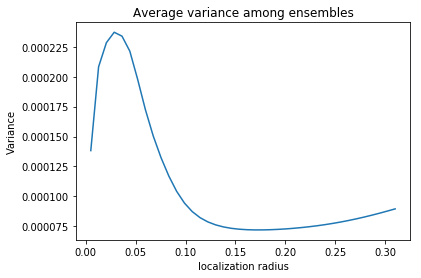

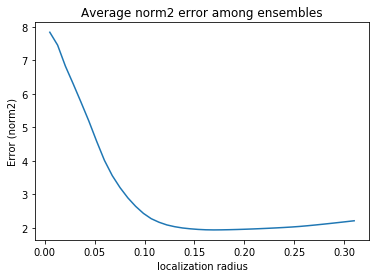

In [232]:
plt.figure()
plt.plot(rho_array, reduced_var.mean(axis=(0, 1)))
plt.title('Average variance among ensembles')
plt.ylabel('Variance')
plt.xlabel('localization radius')

plt.figure()
plt.plot(rho_array, error_n2.mean(axis=-1))
plt.title('Average norm2 error among ensembles')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')

In [235]:
# # vmax = reduced_var.max()
# vmax = None
# for rho_count in range(rho_array.size):
#     imshow(reduced_var[:, :, rho_count],
#            f'Variance for rho: {rho_array[rho_count]:0.4}',
#            vmin=0, vmax=vmax)

Text(0.5,0,'localization radius')

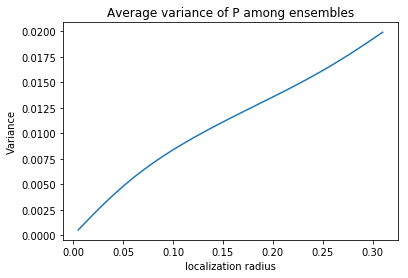

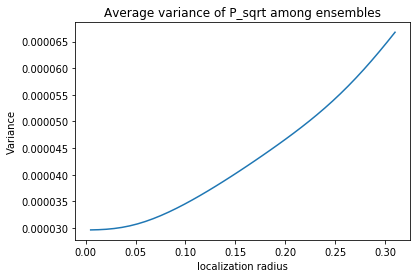

In [233]:
plt.figure()
plt.plot(rho_array, P_var.mean(axis=(0, 1)))
plt.title('Average variance of P among ensembles')
plt.ylabel('Variance')
plt.xlabel('localization radius')

plt.figure()
plt.plot(rho_array, P_sqrt_var.mean(axis=(0, 1)))
plt.title('Average variance of P_sqrt among ensembles')
plt.ylabel('Variance')
plt.xlabel('localization radius')vmax = P_var.max()
# for rho_count in range(rho_array.size):
#     imshow(P_var[:, :, rho_count],
#            f'Variance of P for rho: {rho_array[rho_count]:0.4}',
#            vmin=0, vmax=vmax)

In [234]:
# vmax = P_var.max()
# for rho_count in range(rho_array.size):
#     imshow(P_var[:, :, rho_count],
#            f'Variance of P for rho: {rho_array[rho_count]:0.4}',
#            vmin=0, vmax=vmax)

In [236]:
# vmax = None
# for rho_count in range(rho_array.size):
#     imshow(P_sqrt_var[:, :, rho_count],
#            f'Variance of P_sqrt rho: {rho_array[rho_count]:0.4}',
#            vmin=0, vmax=vmax)

In [237]:
def angle(V0, V1):
    IPs = V0.T @ V1
    norm0 = (V0 ** 2).sum(axis=0)
    norm1 = (V1 ** 2).sum(axis=0)
    norm0 = norm0[:, None]
    norm1 = norm1[None, :]
    sigmas = sp.linalg.svd(
        IPs / np.sqrt(norm0 * norm1),
        compute_uv=False)
    dist = np.arccos(sigmas.min())
    return sigmas.min()

In [238]:
true_V = VT[:sig_num].T
sample_mean_V = V_array.mean(axis=-1)
V_angle_truth2ens = np.ones(
    [1, rho_array.size, ens_ens_size])
V_angle_mean2ens = np.ones(
    [1, rho_array.size, ens_ens_size])
V_angle_truth2mean = np.ones(
    [1, rho_array.size])
for rho_count in range(rho_array.size):
    V_dist = angle(sample_mean_V[:, :, rho_count],
                   true_V)
    V_angle_truth2mean[0, rho_count] = v_dist
    for ens_count in range(ens_ens_size):
        aV = V_array[:, :, rho_count, ens_count]
        V_dist = angle(aV, true_V)
        V_angle_truth2ens[0, rho_count, ens_count] = V_dist
        
        V_dist = angle(aV, sample_mean_V[:, :,  rho_count])
        V_angle_mean2ens[0, rho_count, ens_count] = V_dist
V_angle_truth2ens_var = V_angle_truth2ens.var(axis=-1)
V_angle_truth2ens_mean = V_angle_truth2ens.mean(axis=-1)
V_angle_mean2ens_var = V_angle_mean2ens.var(axis=-1)
V_angle_mean2ens_mean = V_angle_mean2ens.mean(axis=-1)

Text(0.5,1,'Mean of angle from mean')

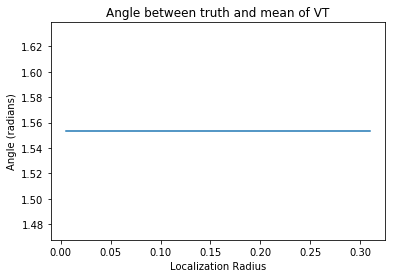

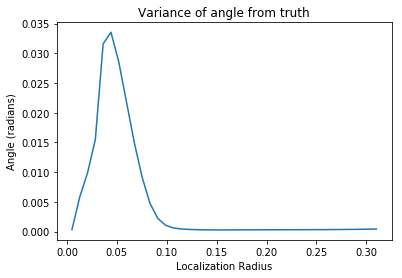

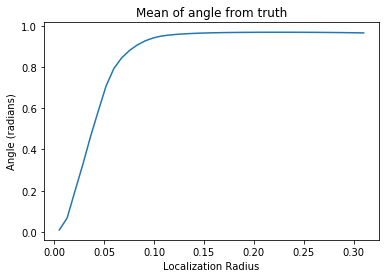

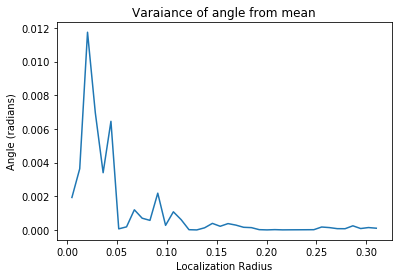

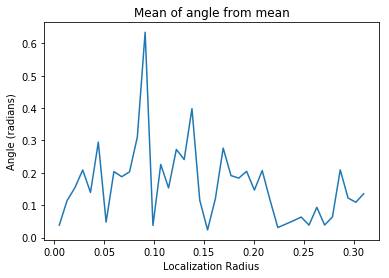

In [239]:
plt.figure()
plt.plot(rho_array, V_angle_truth2mean.ravel())
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Angle between truth and mean of VT')

plt.figure()
plt.plot(rho_array, V_angle_truth2ens_var.ravel())
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Variance of angle from truth')

plt.figure()
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle from truth')

plt.figure()
plt.plot(rho_array, V_angle_mean2ens_var.ravel())
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Varaiance of angle from mean')

plt.figure()
plt.plot(rho_array, V_angle_mean2ens_mean.ravel())
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle from mean')

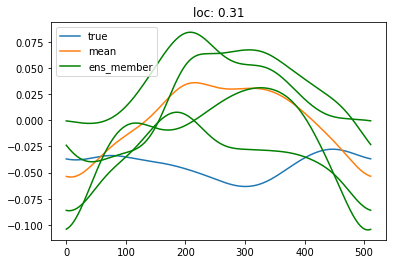

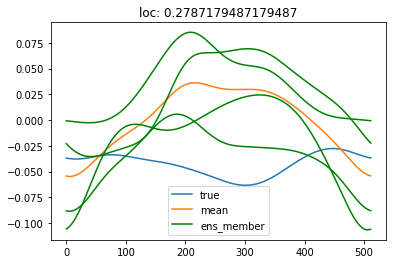

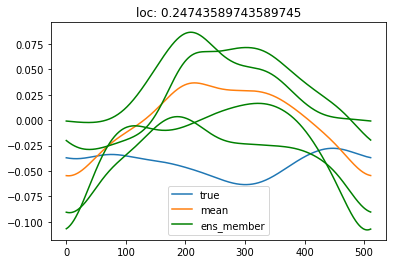

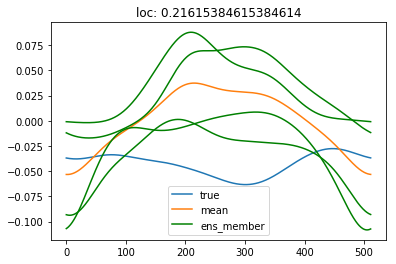

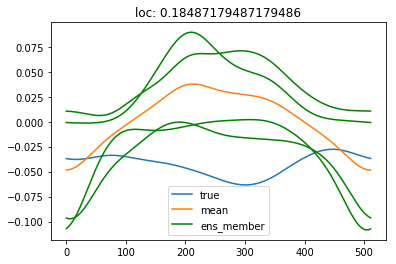

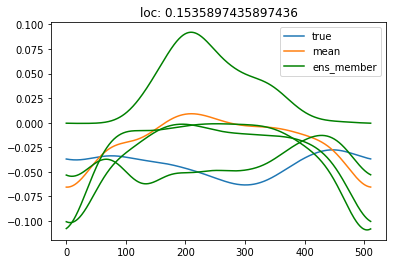

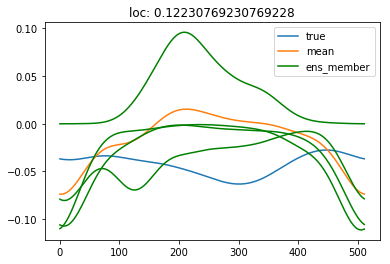

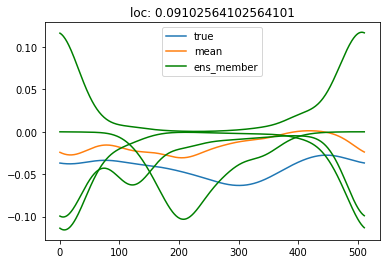

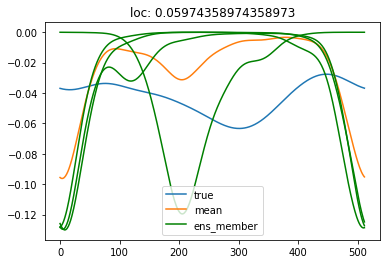

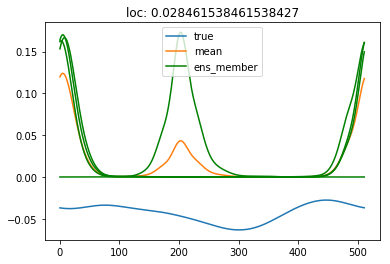

In [218]:
ens_plot_num = 4
for ii in np.arange(rho_array.size)[::4]:
    plt.figure()
    plt.plot(true_V[:, 0])
    plt.plot(sample_mean_V[:, 0, ii])
    for ens_mem in range(ens_plot_num):
        plt.plot(V_array[:, 0, ii, ens_mem], 'g')
    plt.legend(['true', 'mean', 'ens_member'])
    plt.title(f'loc: {rho_array[ii]}')

In [142]:
def angle_1d(v0, v1):
    dist = v0 @ v1
    dist = dist/(
        np.linalg.norm(v0)
        * np.linalg.norm(v1))
    dist = np.arccos(dist)
    return dist

In [160]:
# for only first singular vector
true_v = VT[0]
sample_mean_v = V_array.mean(axis=-1)
v_angle_truth2ens = np.ones(
    [1, rho_array.size, ens_ens_size])
v_angle_mean2ens = np.ones(
    [1, rho_array.size, ens_ens_size])
v_angle_truth2mean = np.ones(
    [1, rho_array.size])
for rho_count in range(rho_array.size):
    v_dist = angle_1d(sample_mean_v[:, rho_count],
                      true_v)
    v_angle_truth2mean[0, rho_count] = v_dist
    for ens_count in range(ens_ens_size):
        av = V_array[:, rho_count, ens_count]
        v_dist = angle_1d(av, true_v)
        v_angle_truth2ens[0, rho_count, ens_count] = v_dist
        
        v_dist = angle_1d(av, sample_mean_v[:, rho_count])
        v_angle_mean2ens[0, rho_count, ens_count] = v_dist
v_angle_truth2ens_var = v_angle_truth2ens.var(axis=-1)
v_angle_truth2ens_mean = v_angle_truth2ens.mean(axis=-1)
v_angle_mean2ens_var = v_angle_mean2ens.var(axis=-1)
v_angle_mean2ens_mean = v_angle_mean2ens.mean(axis=-1)

ValueError: shapes (512,2) and (3,512) not aligned: 2 (dim 1) != 3 (dim 0)

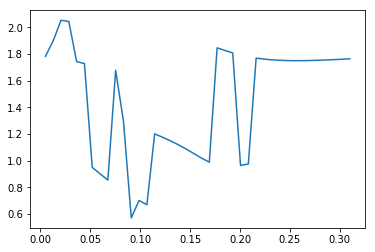

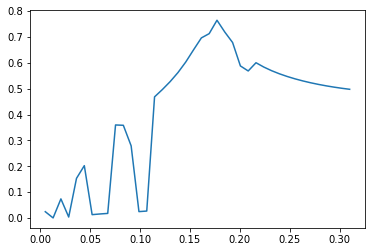

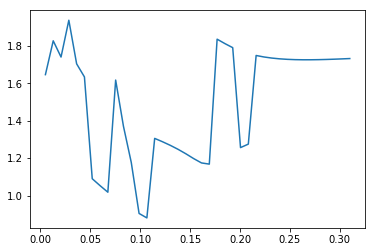

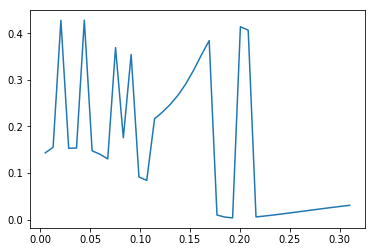

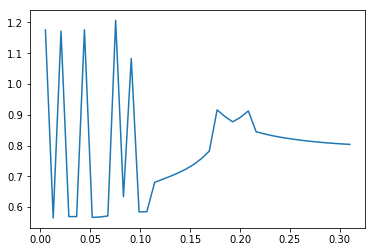

In [151]:
plt.figure()
plt.plot(rho_array, v_angle_truth2mean.ravel())

plt.figure()
plt.plot(rho_array, v_angle_truth2ens_var.ravel())

plt.figure()
plt.plot(rho_array, v_angle_truth2ens_mean.ravel())

plt.figure()
plt.plot(rho_array, v_angle_mean2ens_var.ravel())

plt.figure()
plt.plot(rho_array, v_angle_mean2ens_mean.ravel())
